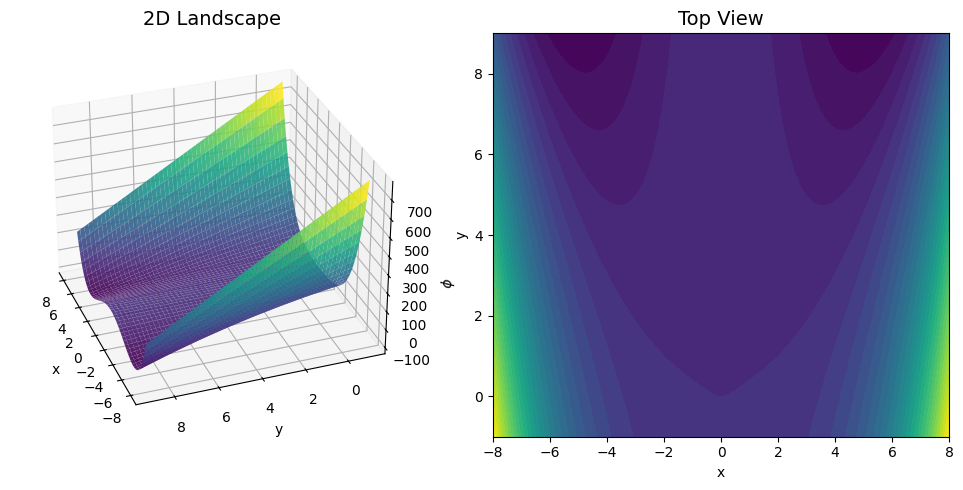

Simulating 1000 particles for 200 steps...


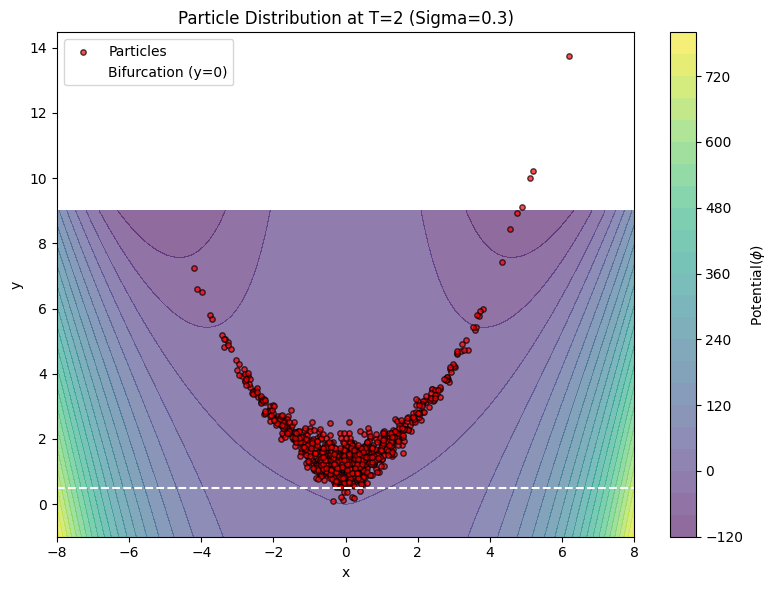

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm



PARAMS = {
    'a': 0.5,    # Bifurcation point (y=0)
    'b': 1/6,    # x-scale stability, distance between branches^-1
    'c': 2/3,  # Drive strength (tilt), distance between bifurcation and new stable points
    'd': 0  # Wall steepness
}

# Simulation controls
N_PARTICLES = 1000
T_TOTAL = 2        # Total duration
dt = 0.01            # Time step size
n_steps = int(T_TOTAL / dt)
sigma = 0.3          # Noise
x0 = 0.0    # Initial x position (near the unstable point)
dx = 0.05  # Initial noise scale for x
y0 = 0   # Initial y position (before bifurcation)
dy = 0.05  # Initial noise scale for y



# initialize particles
particles_x = np.random.normal(x0, dx, N_PARTICLES)
particles_y = np.random.normal(y0, dy, N_PARTICLES)

def potential(x, y, p):
    """ H= -(y - a)x^2 + b x^4 - c y + d y^4 """
    return -(y - p['a']) * (x**2) + p['b'] * (x**4) - p['c'] * y + p['d'] * (y**4)

def force(x, y, p):
    """
    Fx = -dH/dx, Fy = -dH/dy
    """
    # Force in x: 2(y-a)x - 4bx^3
    fx = 2 * (y - p['a']) * x - 4 * p['b'] * (x**3)
    
    # Force in y: x^2 + c - 4dy^3
    fy = (x**2) + p['c'] - 4 * p['d'] * (y**3)
    
    return fx, fy

# --- Plot Setup ---

x = np.linspace(-8, 8, 200)
y = np.linspace(-1, 9, 200)
X, Y = np.meshgrid(x, y)
Z = potential(X, Y, p=PARAMS)

# --- Plotting ---

fig = plt.figure(figsize=(10, 5))

# Subplot 1: 3D Surface Plot
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.9, edgecolor='none')
ax1.set_title("2D Landscape", fontsize=14)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("$\phi$")
# Adjust view angle to see the branching clearly
ax1.view_init(elev=30, azim=160) 

# Subplot 2: Contour Plot (Top-down view)
ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(X, Y, Z, levels=30, cmap=cm.viridis)
ax2.set_title("Top View", fontsize=14)
ax2.set_xlabel("x")
ax2.set_ylabel("y")

plt.tight_layout()
plt.show()

# --- Run Simulation (Euler-Maruyama) ---

print(f"Simulating {N_PARTICLES} particles for {n_steps} steps...")

for step in range(n_steps):
    # Calculate deterministic force (Drift)
    fx, fy = force(particles_x, particles_y, PARAMS)
    
    # Generate random noise (Diffusion)
    # Scale by sqrt(dt) strictly according to SDE theory
    noise_x = np.random.normal(0, 1, N_PARTICLES) * np.sqrt(dt)
    noise_y = np.random.normal(0, 1, N_PARTICLES) * np.sqrt(dt)
    
    # Update positions
    particles_x += fx * dt + sigma * noise_x
    particles_y += fy * dt + sigma * noise_y

# --- Visualization ---

plt.figure(figsize=(8, 6))

# Plot the Landscape Contour
# We use negative Z for shading so valleys look darker/deeper if using some colormaps,
# but here standard viridis works well.
contour = plt.contourf(X, Y, Z, levels=25, cmap='viridis', alpha=0.6)
plt.colorbar(contour, label='Potential($\phi$)')

# Plot the Particles
# We plot them as red dots with black edges for visibility
plt.scatter(particles_x, particles_y, color='red', s=15, alpha=0.7, edgecolors='black', label='Particles')

# Mark the bifurcation line
plt.axhline(PARAMS['a'], color='white', linestyle='--', label='Bifurcation (y=0)')

plt.title(f"Particle Distribution at T={T_TOTAL} (Sigma={sigma})")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
import ipywidgets as widgets  # Import the Jupyter-native widgets
from IPython.display import display

# Initialize
p_x = np.random.normal(x0, dx, N_PARTICLES)
p_y = np.random.normal(y0, dy, N_PARTICLES)

# History arrays
history_x = np.zeros((n_steps, N_PARTICLES))
history_y = np.zeros((n_steps, N_PARTICLES))

for i in range(n_steps):
    history_x[i] = p_x
    history_y[i] = p_y
    fx, fy = force(p_x, p_y, PARAMS)
    noise_x = np.random.normal(0, 1, N_PARTICLES) * np.sqrt(dt)
    noise_y = np.random.normal(0, 1, N_PARTICLES) * np.sqrt(dt)
    p_x += fx * dt + sigma * noise_x
    p_y += fy * dt + sigma * noise_y

# --- Visualization with Interactive Slider ---
def plot_frame(step_index):
    """
    Renders a single frame.
    Note: We create a new figure every time because 'blitting' (updating points)
    is complex to set up in VS Code without installing extra extensions like ipympl.
    """
    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot Background
    ax.contourf(X, Y, Z, levels=25, cmap='viridis', alpha=0.6)
    ax.axhline(PARAMS['a'], color='white', linestyle='--', alpha=0.5, label='Bifurcation')
    
    # Plot Particles
    current_x = history_x[step_index]
    current_y = history_y[step_index]
    ax.scatter(current_x, current_y, c='red', s=15, edgecolors='black', alpha=0.8)
    
    # Labels
    ax.set_title(f"Time: {step_index * dt:.2f} / {T_TOTAL:.2f}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    
    plt.show() 

# --- The Fix for VS Code ---
# 1. Create the interactive widget object but DO NOT display it yet.
#    We map the 'step_index' argument to an integer slider.
ui = widgets.interactive(
    plot_frame, 
    step_index=widgets.IntSlider(
        min=0, 
        max=n_steps-1, 
        step=5,           # Skip 5 steps for faster dragging
        value=0, 
        description='Time Step',
        continuous_update=False # Prevents lagging while dragging
    )
)

# 2. Display the UI object explicitly.
display(ui)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Time Step', max=199, step=5), O…

In [4]:
# MMD Parameter Inference

# 1. Generate Fake "Real Cell Data" (Target)
target_params = PARAMS.copy()

# Helper function to run sim and get just coordinates
def get_sim_data(p, steps=200):
    px = np.random.normal(x0, dx, N_PARTICLES)
    py = np.random.normal(y0, dy, N_PARTICLES)
    sq_dt = np.sqrt(dt)
    
    for _ in range(steps):
        fx, fy = force(px, py, p)
        px += fx * dt + sigma * np.random.normal(0, 1, N_PARTICLES) * sq_dt
        py += fy * dt + sigma * np.random.normal(0, 1, N_PARTICLES) * sq_dt
    return np.column_stack((px, py))

target_data = get_sim_data(target_params) # Shape: (N, 2)


# 2. Compact MMD Loss Function
def mmd_loss(x, y, bandwidth=1.5):
    """
    Calculates MMD squared: E[K(x,x)] + E[K(y,y)] - 2E[K(x,y)]
    """
    def k_mean(a, b):
        # 1. Expand dims for broadcasting: (N, 1, 2) - (1, M, 2)
        diff = a[:, None, :] - b[None, :, :]
        # 2. Squared Euclidean distance
        dist_sq = np.sum(diff**2, axis=-1)
        # 3. Gaussian Kernel & Mean
        return np.exp(-dist_sq / (2 * bandwidth**2)).mean()

    # MMD Formula
    return k_mean(x, x) + k_mean(y, y) - 2 * k_mean(x, y)


# Gradient Descent

current_params = {'a':0, 'b':0.5, 'c':3, 'd':0.1 }

# Learning Rate
lr_c = 0.2 
lr_d = 0.02 

print(f"Target c: {target_params['c']}, Start c: {current_params['c']}")
print(f"Target d: {target_params['d']}, Start d: {current_params['d']}")

epsilon = 0.001

for i in range(100): 
    
    # 1. Loss
    base_data = get_sim_data(current_params, steps=n_steps)
    base_loss = mmd_loss(base_data, target_data)
    
    # 2. Slope for c
    test_params_c = current_params.copy()
    test_params_c['c'] += epsilon 
    
    test_data_c = get_sim_data(test_params_c, steps=n_steps)
    test_loss_c = mmd_loss(test_data_c, target_data)
    
    grad_c = (test_loss_c - base_loss) / epsilon
    
    # 3. Slope for d
        
    test_params_d = current_params.copy()
    test_params_d['d'] += epsilon
    
    test_data_d = get_sim_data(test_params_d, steps=n_steps)
    test_loss_d = mmd_loss(test_data_d, target_data)
    
    grad_d = (test_loss_d - base_loss) / epsilon 
    
    # 4. Update
    
    current_params['c'] -= lr_c * grad_c
    current_params['d'] -= lr_d * grad_d

    if current_params['d'] < 0.001:
        current_params['d'] = 0.001
        
    if current_params['c'] < 0.001:
        current_params['c'] = 0.001

    if base_loss < 0.001:
        break
    
    print(f"Iter {i}: Loss={base_loss:.5f}")
    print(f"    Grad c={grad_c:.4f} -> Update c to {current_params['c']:.3f}")
    print(f"    Grad d={grad_d:.4f} -> Update d to {current_params['d']:.4f}")

print(f"Final Estimated c: {current_params['c']:.3f} (True: {target_params['c']})")
print(f"Final Estimated d: {current_params['d']:.3f} (True: {target_params['d']})")

Target c: 2, Start c: 3
Target d: 0.05, Start d: 0.1
Iter 0: Loss=0.00861
    Grad c=-0.9907 -> Update c to 3.198
    Grad d=0.0045 -> Update d to 0.0999
Iter 1: Loss=0.00726
    Grad c=0.5931 -> Update c to 3.080
    Grad d=-0.2111 -> Update d to 0.1041
Iter 2: Loss=0.00813
    Grad c=1.1910 -> Update c to 2.841
    Grad d=0.6006 -> Update d to 0.0921
Iter 3: Loss=0.00763
    Grad c=-0.2976 -> Update c to 2.901
    Grad d=0.2987 -> Update d to 0.0861
Iter 4: Loss=0.00914
    Grad c=0.0350 -> Update c to 2.894
    Grad d=-1.1600 -> Update d to 0.1093
Iter 5: Loss=0.01307
    Grad c=-1.1556 -> Update c to 3.125
    Grad d=1.2922 -> Update d to 0.0835
Iter 6: Loss=0.01327
    Grad c=-0.4994 -> Update c to 3.225
    Grad d=-0.3866 -> Update d to 0.0912
Iter 7: Loss=0.00938
    Grad c=-0.6307 -> Update c to 3.351
    Grad d=-0.7984 -> Update d to 0.1072
Iter 8: Loss=0.00804
    Grad c=3.6023 -> Update c to 2.631
    Grad d=0.5216 -> Update d to 0.0968
Iter 9: Loss=0.00875
    Grad c=1.4624

Running on: cpu
Generating target data (True c=3.5, d=0.1)...
Scanning Loss Landscape (Grid Search)... This may take a minute.
Grid Search Best: c=4.763, d=0.120


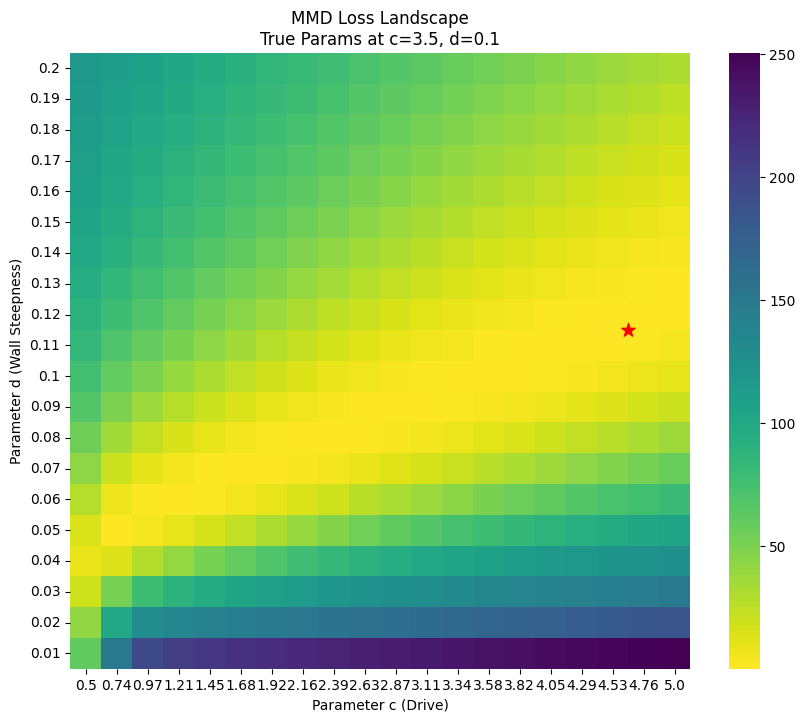

Refining from Grid Best: [np.float64(4.763157894736842), np.float64(0.12)]...
Optimization terminated successfully.
         Current function value: 0.004232
         Iterations: 28
         Function evaluations: 66

Final Result:
True:      c=3.5, d=0.1
Estimated: c=4.755, d=0.120


In [5]:
import torch
from scipy.optimize import minimize
import seaborn as sns

# --- 1. PyTorch Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

DT_T = torch.tensor(dt, device=device)
SQRT_DT_T = torch.sqrt(DT_T)

def simulate_torch(params_list, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    c, d = params_list
    a = PARAMS['a']
    b = PARAMS['b']

    _x0 = x0[0] if isinstance(x0, list) else x0
    _y0 = y0[0] if isinstance(y0, list) else y0
    _dx = dx[0] if isinstance(dx, list) else dx
    _dy = dy[0] if isinstance(dy, list) else dy

    x = torch.randn(N_PARTICLES, device=device) * _dx + _x0
    y = torch.randn(N_PARTICLES, device=device) * _dy + _y0

    for _ in range(n_steps):
        fx = 2 * (y - a) * x - 4 * b * (x**3)
        fy = (x**2) + c - 4 * d * (y**3)

        noise_x = torch.randn(N_PARTICLES, device=device)
        noise_y = torch.randn(N_PARTICLES, device=device)

        x += fx * DT_T + sigma * noise_x * SQRT_DT_T
        y += fy * DT_T + sigma * noise_y * SQRT_DT_T

    return torch.stack((x, y), dim=1)

def calc_multiscale_mmd(x, y, bandwidths=[0.5, 2.0, 5.0]):
    xx_dist = torch.cdist(x, x)
    yy_dist = torch.cdist(y, y)
    xy_dist = torch.cdist(x, y)
    total_loss = 0.0
    for bw in bandwidths:
        gamma = 1.0 / (2 * bw**2)
        k_xx = torch.exp(-gamma * xx_dist**2).mean()
        k_yy = torch.exp(-gamma * yy_dist**2).mean()
        k_xy = torch.exp(-gamma * xy_dist**2).mean()
        total_loss += (k_xx + k_yy - 2 * k_xy)
    return total_loss

# --- 2. Generate Ground Truth ---
print("Generating target data (True c=3.5, d=0.1)...")
target_data = simulate_torch([3.5, 0.1], seed=999)

# --- 3. Grid Search & Visualization ---

print("Scanning Loss Landscape (Grid Search)... This may take a minute.")

c_range = np.linspace(0.5, 5.0, 20)  # 尝试 20 个 c
d_range = np.linspace(0.01, 0.2, 20) # 尝试 20 个 d

loss_grid = np.zeros((len(d_range), len(c_range)))
best_loss_grid = float('inf')
best_params_grid = [0, 0]

# scan the grid
for i, d_val in enumerate(d_range):
    for j, c_val in enumerate(c_range):
        # 使用 seed=42 保证评估的一致性
        sim = simulate_torch([c_val, d_val], seed=42)
        loss = calc_multiscale_mmd(sim, target_data).item() * 100
        
        loss_grid[i, j] = loss
        
        if loss < best_loss_grid:
            best_loss_grid = loss
            best_params_grid = [c_val, d_val]

print(f"Grid Search Best: c={best_params_grid[0]:.3f}, d={best_params_grid[1]:.3f}")

# --- 4. Plot Heatmap ---
plt.figure(figsize=(10, 8))
ax = sns.heatmap(loss_grid, xticklabels=np.round(c_range, 2), yticklabels=np.round(d_range, 3), cmap="viridis_r", annot=False)
ax.invert_yaxis() 
plt.xlabel("Parameter c (Drive)")
plt.ylabel("Parameter d (Wall Steepness)")
plt.title(f"MMD Loss Landscape\nTrue Params at c=3.5, d=0.1")
# mark the best point found by grid search
plt.scatter(np.searchsorted(c_range, best_params_grid[0]), np.searchsorted(d_range, best_params_grid[1]), c='red', s=100, marker='*', label='Grid Minimum')
plt.show()

# --- 5. Fine-Tuning with Nelder-Mead ---
# 使用网格搜索的结果作为初始点，而不是瞎猜的 [2.0, 0.05]

print(f"Refining from Grid Best: {best_params_grid}...")

def objective(p):
    c_val, d_val = p
    if d_val < 0.001 or c_val < 0: return 1e6
    sim_data = simulate_torch([c_val, d_val], seed=42)
    return calc_multiscale_mmd(sim_data, target_data).item() * 100

res = minimize(
    objective, 
    best_params_grid, # <--- key: from the best point
    method='Nelder-Mead', 
    options={'disp': True, 'maxiter': 50, 'xatol': 1e-4}
)

print("\n" + "="*30)
print(f"Final Result:")
print(f"True:      c=3.5, d=0.1")
print(f"Estimated: c={res.x[0]:.3f}, d={res.x[1]:.3f}")
print("="*30)